# Speech Command Recognition: CNN vs Traditional ML

This notebook compares two approaches for speech command recognition:
1. **Baseline CNN** using Spectrogram (STFT) features
2. **Traditional ML Models** using MFCC features

**Authors:** Nicholas Hefner, Arthur Ho, Hsuan-Yu Lin

## Overview
- **Dataset:** Google Speech Commands Dataset (mini version)
- **Commands:** 8 classes (down, go, left, no, right, stop, up, yes)
- **Purpose:** Compare deep learning vs classical ML approaches for audio classification


---
# Part 0: Setup and Data Loading
---


## 0.1 Import Libraries


In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import librosa
import librosa.display
from tqdm import tqdm

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Set seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Create directories
os.makedirs('figures', exist_ok=True)
os.makedirs('models', exist_ok=True)

print(f"TensorFlow version: {tf.__version__}")
print("Libraries imported successfully!")


2025-12-07 09:44:20.068131: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-07 09:44:20.723877: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-07 09:44:22.776053: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow version: 2.20.0
Libraries imported successfully!


## 0.2 Load Dataset


In [2]:
# Dataset path
DATASET_PATH = 'data/mini_speech_commands_extracted/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

# Audio parameters
SAMPLE_RATE = 16000  # 16 kHz
AUDIO_LENGTH = 16000  # 1 second of audio
DURATION = 1.0  # seconds

# List commands
commands = np.array([d.name for d in data_dir.iterdir() if d.is_dir()])
print(f"Commands: {commands}")
print(f"Number of commands: {len(commands)}")


Commands: ['down' 'left' 'go' 'right' 'yes' 'no' 'stop' 'up']
Number of commands: 8


In [3]:
# Count files per command
print("Files per command:")
for cmd in sorted(commands):
    cmd_path = data_dir / cmd
    if cmd_path.is_dir():
        num_files = len(list(cmd_path.glob('*.wav')))
        print(f"  {cmd}: {num_files} files")


Files per command:
  down: 1000 files
  go: 1000 files
  left: 1000 files
  no: 1000 files
  right: 1000 files
  stop: 1000 files
  up: 1000 files
  yes: 1000 files


---
# Part 1: Baseline CNN with Spectrograms
---


## 1.1 Prepare TensorFlow Datasets


In [4]:
BATCH_SIZE = 64

# Create training and validation datasets
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    seed=SEED,
    output_sequence_length=AUDIO_LENGTH,
    subset='both'
)

# Get label names
label_names = np.array(train_ds.class_names)
print(f"Label names: {label_names}")


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
Label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


E0000 00:00:1765129464.991497  437723 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765129465.008424  437723 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# Squeeze to remove channel dimension for mono audio
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# Split validation into validation and test sets
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

# Check shapes
for example_audio, example_labels in train_ds.take(1):
    print(f"Audio batch shape: {example_audio.shape}")
    print(f"Labels batch shape: {example_labels.shape}")


Audio batch shape: (64, 16000)
Labels batch shape: (64,)


2025-12-07 09:44:25.154887: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 1.2 Convert Audio to Spectrograms


In [6]:
def get_spectrogram(waveform):
    """
    Convert waveform to spectrogram using Short-Time Fourier Transform (STFT).
    """
    spectrogram = tf.signal.stft(
        waveform, 
        frame_length=255,
        frame_step=128
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# Test spectrogram function
for audio, label in train_ds.take(1):
    example_audio = audio[0]
    example_label = label[0]
    
spectrogram = get_spectrogram(example_audio)
print(f"Waveform shape: {example_audio.shape}")
print(f"Spectrogram shape: {spectrogram.shape}")


Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)


2025-12-07 09:44:25.191751: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


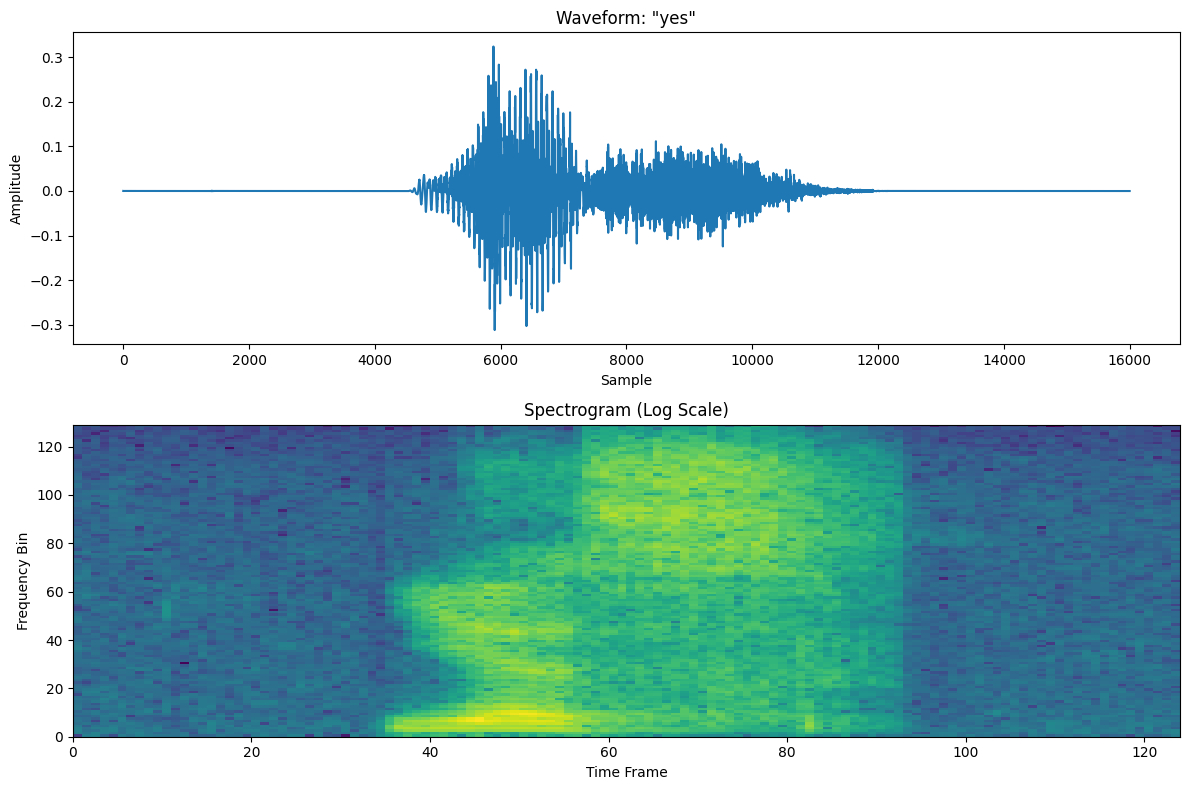

In [7]:
# Visualize waveform and spectrogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Waveform
axes[0].plot(example_audio.numpy())
axes[0].set_title(f'Waveform: "{label_names[example_label]}"')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Amplitude')

# Spectrogram
log_spec = np.log(spectrogram.numpy()[:, :, 0].T + np.finfo(float).eps)
axes[1].pcolormesh(log_spec, shading='auto', cmap='viridis')
axes[1].set_title('Spectrogram (Log Scale)')
axes[1].set_xlabel('Time Frame')
axes[1].set_ylabel('Frequency Bin')

plt.tight_layout()
plt.savefig('figures/spectrogram_example.png', dpi=150, bbox_inches='tight')
plt.show()


In [8]:
# Create spectrogram datasets
def make_spec_ds(ds):
    return ds.map(
        lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

# Optimize performance
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

# Check shapes
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
    print(f"Spectrogram batch shape: {example_spectrograms.shape}")


Spectrogram batch shape: (64, 124, 129, 1)


## 1.3 Build and Train CNN Model


In [9]:
# Get input shape
for example_spectrograms, _ in train_spectrogram_ds.take(1):
    input_shape = example_spectrograms.shape[1:]
    
print(f"Input shape: {input_shape}")
num_labels = len(label_names)
print(f"Number of labels: {num_labels}")

# Normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(lambda spec, label: spec))


Input shape: (124, 129, 1)
Number of labels: 8


2025-12-07 09:44:26.945672: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Build CNN model
cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 124, 129, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 122, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 120, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 238080)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    30,474,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,494,219 (116.33 MB)

 Trainable params: 30,494,216 (116.33 MB)

 Non-trainable params: 3 (16.00 B)

In [11]:
# Train CNN
EPOCHS = 10

cnn_history = cnn_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 72s 712ms/step - accuracy: 0.3773 - loss: 1.8239 - val_accuracy: 0.5742 - val_loss: 1.2882
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - accuracy: 0.6227 - loss: 1.1214 - val_accuracy: 0.6901 - val_loss: 0.9389
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.7461 - loss: 0.7628 - val_accuracy: 0.7539 - val_loss: 0.7755
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 712ms/step - accuracy: 0.8053 - loss: 0.5766 - val_accuracy: 0.7799 - val_loss: 0.6849
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 711ms/step - accuracy: 0.8531 - loss: 0.4367 - val_accuracy: 0.7878 - val_loss: 0.6657
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 671ms/step - accuracy: 0.8808 - loss: 0.3587 - val_accuracy: 0.8073 - val_loss: 0.6299
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 71s 706ms/step - accuracy: 0.9047 - loss: 0.3010 - val_accuracy: 0.7917 - val_loss: 0.6176
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 694ms/step - accuracy: 0.9156 - loss: 0

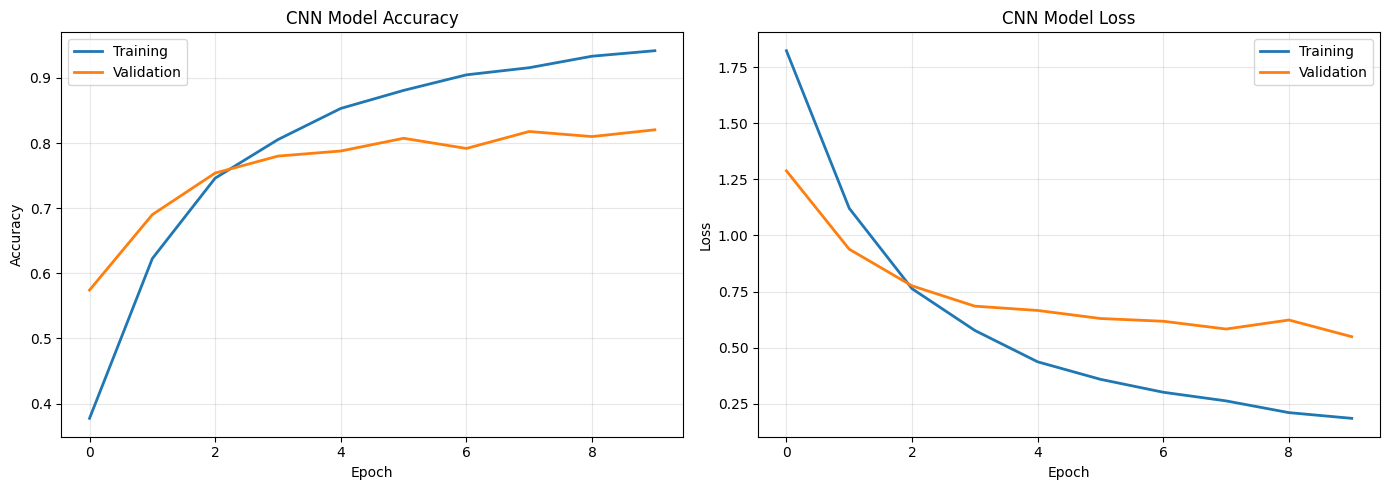

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cnn_history.history['accuracy'], label='Training', linewidth=2)
axes[0].plot(cnn_history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('CNN Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(cnn_history.history['loss'], label='Training', linewidth=2)
axes[1].plot(cnn_history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('CNN Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()


## 1.4 Evaluate CNN Model


In [13]:
# Evaluate on test set
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_spectrogram_ds)
print(f"\nCNN Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"CNN Test Loss: {cnn_test_loss:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.8317 - loss: 0.6853

CNN Test Accuracy: 0.8317
CNN Test Loss: 0.6853


In [14]:
# Generate predictions for confusion matrix
cnn_y_pred = []
cnn_y_true = []

for spectrograms, labels in test_spectrogram_ds:
    predictions = cnn_model.predict(spectrograms, verbose=0)
    cnn_y_pred.extend(np.argmax(predictions, axis=1))
    cnn_y_true.extend(labels.numpy())

cnn_y_pred = np.array(cnn_y_pred)
cnn_y_true = np.array(cnn_y_true)


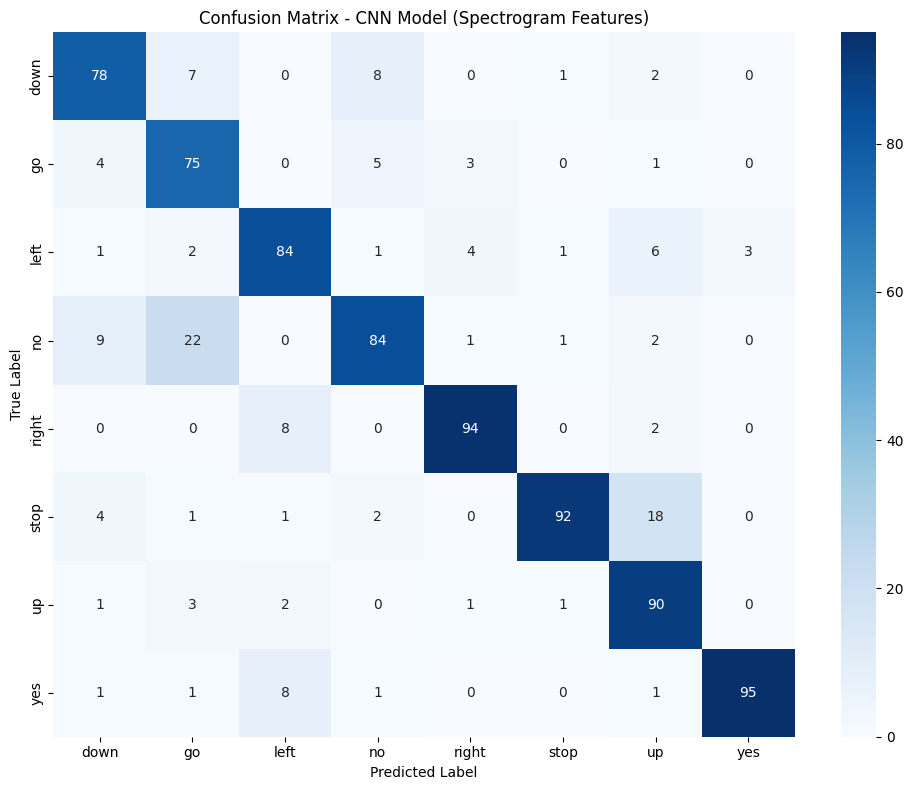


CNN Classification Report:
              precision    recall  f1-score   support

        down       0.80      0.81      0.80        96
          go       0.68      0.85      0.75        88
        left       0.82      0.82      0.82       102
          no       0.83      0.71      0.76       119
       right       0.91      0.90      0.91       104
        stop       0.96      0.78      0.86       118
          up       0.74      0.92      0.82        98
         yes       0.97      0.89      0.93       107

    accuracy                           0.83       832
   macro avg       0.84      0.84      0.83       832
weighted avg       0.84      0.83      0.83       832



In [15]:
# CNN Confusion matrix
cnn_cm = confusion_matrix(cnn_y_true, cnn_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN Model (Spectrogram Features)')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_cnn.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCNN Classification Report:")
print("=" * 60)
print(classification_report(cnn_y_true, cnn_y_pred, target_names=label_names))


In [16]:
# Save CNN model
cnn_model.save('models/baseline_cnn_model.keras')
print("CNN model saved to 'models/baseline_cnn_model.keras'")


CNN model saved to 'models/baseline_cnn_model.keras'


---
# Part 2: Traditional ML with MFCC Features
---


## 2.1 Extract MFCC Features

MFCC (Mel-Frequency Cepstral Coefficients) are commonly used features for speech recognition. They capture the power spectrum of audio in a way that mimics human auditory perception.


In [17]:
# MFCC parameters
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512

def extract_mfcc(file_path, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    Extract MFCC features from an audio file.
    Returns mean MFCC + delta + delta-delta features.
    """
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        
        # Pad or trim
        target_length = int(SAMPLE_RATE * DURATION)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)))
        else:
            audio = audio[:target_length]
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Combine features (mean across time)
        features = np.concatenate([
            np.mean(mfcc, axis=1),
            np.mean(mfcc_delta, axis=1),
            np.mean(mfcc_delta2, axis=1)
        ])
        
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


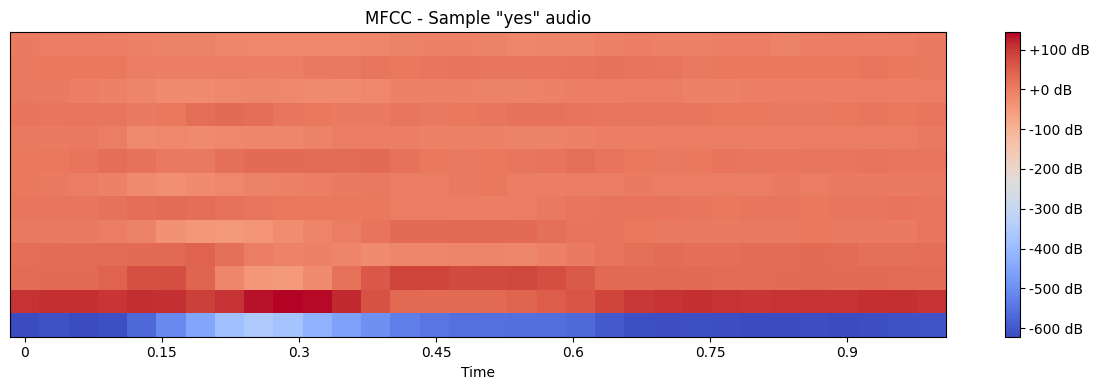

MFCC shape: (13, 32)


In [18]:
# Visualize MFCC for a sample
sample_file = list((data_dir / 'yes').glob('*.wav'))[0]
audio, sr = librosa.load(sample_file, sr=SAMPLE_RATE)
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=N_MFCC)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time', sr=sr, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - Sample "yes" audio')
plt.tight_layout()
plt.savefig('figures/mfcc_example.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"MFCC shape: {mfcc.shape}")


In [19]:
# Extract features from all audio files
X_mfcc = []
y_mfcc = []

print("Extracting MFCC features from all audio files...")
for command in tqdm(sorted(commands)):
    command_dir = data_dir / command
    for audio_file in command_dir.glob('*.wav'):
        features = extract_mfcc(str(audio_file))
        if features is not None:
            X_mfcc.append(features)
            y_mfcc.append(command)

X_mfcc = np.array(X_mfcc)
y_mfcc = np.array(y_mfcc)

print(f"\nFeature matrix shape: {X_mfcc.shape}")
print(f"Labels shape: {y_mfcc.shape}")
print(f"Feature vector length: {X_mfcc.shape[1]} (13 MFCC + 13 delta + 13 delta-delta)")


Extracting MFCC features from all audio files...


100%|██████████| 8/8 [00:27<00:00,  3.49s/it]


Feature matrix shape: (8000, 39)
Labels shape: (8000,)
Feature vector length: 39 (13 MFCC + 13 delta + 13 delta-delta)


## 2.2 Prepare Data for Training


In [20]:
# Encode labels
mfcc_label_encoder = LabelEncoder()
y_mfcc_encoded = mfcc_label_encoder.fit_transform(y_mfcc)
print(f"Classes: {mfcc_label_encoder.classes_}")

# Split data
X_train_mfcc, X_test_mfcc, y_train_mfcc, y_test_mfcc = train_test_split(
    X_mfcc, y_mfcc_encoded, test_size=0.2, random_state=SEED, stratify=y_mfcc_encoded
)

print(f"Training set size: {len(X_train_mfcc)}")
print(f"Test set size: {len(X_test_mfcc)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mfcc)
X_test_scaled = scaler.transform(X_test_mfcc)

print("Features scaled using StandardScaler")


Classes: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']
Training set size: 6400
Test set size: 1600
Features scaled using StandardScaler


## 2.3 Train Traditional ML Models


In [21]:
# Define models
ml_models = {
    'SVM (RBF)': SVC(kernel='rbf', random_state=SEED),
    'SVM (Linear)': SVC(kernel='linear', random_state=SEED),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=SEED),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
}

ml_results = {}


In [22]:
# Train and evaluate each model
for name, model in ml_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train_mfcc)
    
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test_mfcc, y_pred)
    ml_results[name] = accuracy
    
    print(f"{name} Test Accuracy: {accuracy:.4f}")



Training SVM (RBF)...
SVM (RBF) Test Accuracy: 0.5200

Training SVM (Linear)...
SVM (Linear) Test Accuracy: 0.4144

Training Random Forest...
Random Forest Test Accuracy: 0.4594

Training KNN (k=5)...
KNN (k=5) Test Accuracy: 0.3688


## 2.4 Evaluate Best Traditional ML Model


In [23]:
# Find best model
best_ml_name = max(ml_results, key=ml_results.get)
best_ml_model = ml_models[best_ml_name]
best_ml_accuracy = ml_results[best_ml_name]
print(f"Best ML model: {best_ml_name} with accuracy: {best_ml_accuracy:.4f}")

# Get predictions
ml_y_pred = best_ml_model.predict(X_test_scaled)
ml_y_true = y_test_mfcc


Best ML model: SVM (RBF) with accuracy: 0.5200


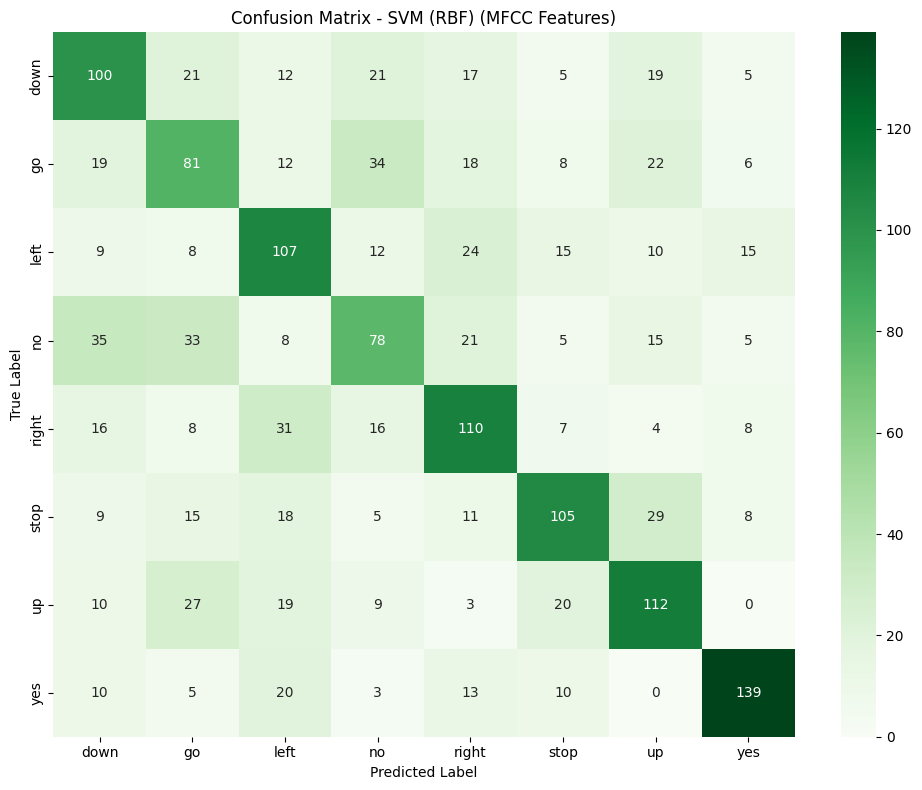


SVM (RBF) Classification Report:
              precision    recall  f1-score   support

        down       0.48      0.50      0.49       200
          go       0.41      0.41      0.41       200
        left       0.47      0.54      0.50       200
          no       0.44      0.39      0.41       200
       right       0.51      0.55      0.53       200
        stop       0.60      0.53      0.56       200
          up       0.53      0.56      0.55       200
         yes       0.75      0.69      0.72       200

    accuracy                           0.52      1600
   macro avg       0.52      0.52      0.52      1600
weighted avg       0.52      0.52      0.52      1600



In [24]:
# Confusion matrix for best ML model
ml_cm = confusion_matrix(ml_y_true, ml_y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    ml_cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=mfcc_label_encoder.classes_,
    yticklabels=mfcc_label_encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - {best_ml_name} (MFCC Features)')
plt.tight_layout()
plt.savefig('figures/confusion_matrix_mfcc.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n{best_ml_name} Classification Report:")
print("=" * 60)
print(classification_report(ml_y_true, ml_y_pred, target_names=mfcc_label_encoder.classes_))


---
# Part 3: Comparative Analysis
---


## 3.1 Overall Results Summary


In [25]:
# Compile all results
all_results = {
    'CNN (Spectrogram)': cnn_test_accuracy,
    **ml_results
}

# Sort by accuracy
sorted_results = dict(sorted(all_results.items(), key=lambda x: x[1], reverse=True))

print("\n" + "=" * 60)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 60)
print(f"{'Rank':<6} {'Model':<25} {'Features':<15} {'Accuracy':<10}")
print("-" * 60)
for rank, (name, acc) in enumerate(sorted_results.items(), 1):
    features = 'Spectrogram' if 'CNN' in name else 'MFCC'
    print(f"{rank:<6} {name:<25} {features:<15} {acc:.4f}")
print("-" * 60)



COMPREHENSIVE MODEL COMPARISON
Rank   Model                     Features        Accuracy  
------------------------------------------------------------
1      CNN (Spectrogram)         Spectrogram     0.8317
2      SVM (RBF)                 MFCC            0.5200
3      Random Forest             MFCC            0.4594
4      SVM (Linear)              MFCC            0.4144
5      KNN (k=5)                 MFCC            0.3688
------------------------------------------------------------


## 3.2 Visual Comparison: All Models


/tmp/ipykernel_437723/265578495.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_names, rotation=45, ha='right')


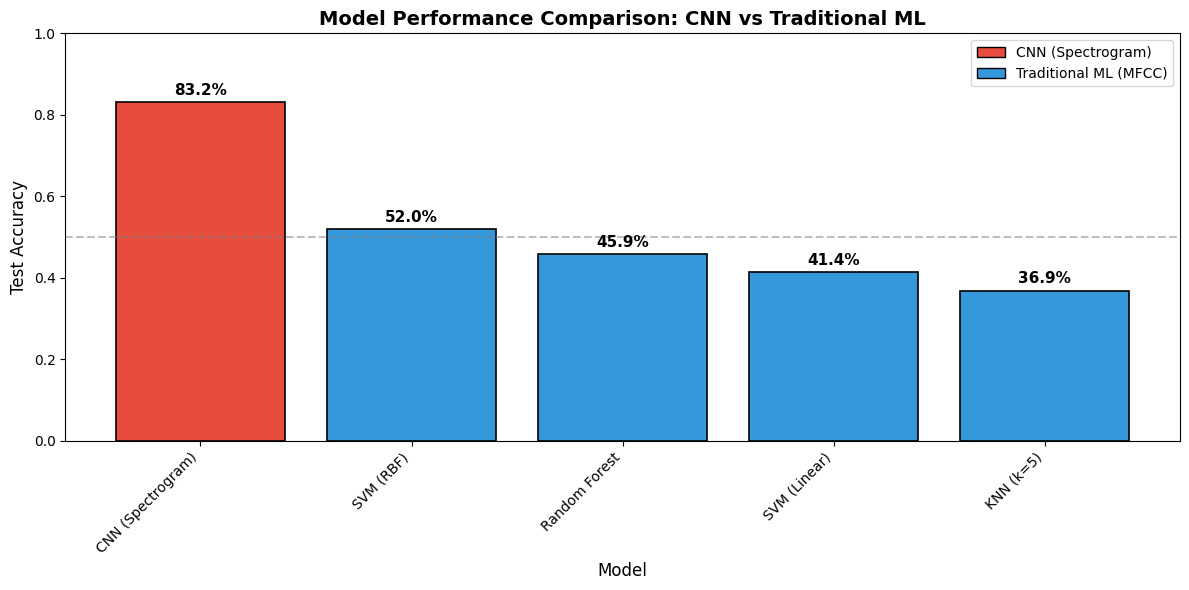

In [26]:
# Bar chart comparison
from matplotlib.patches import Patch

fig, ax = plt.subplots(figsize=(12, 6))

model_names = list(sorted_results.keys())
accuracies = list(sorted_results.values())
colors = ['#e74c3c' if 'CNN' in name else '#3498db' for name in model_names]

bars = ax.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{acc:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Test Accuracy', fontsize=12)
ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Performance Comparison: CNN vs Traditional ML', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
ax.set_xticklabels(model_names, rotation=45, ha='right')

# Legend
legend_elements = [
    Patch(facecolor='#e74c3c', edgecolor='black', label='CNN (Spectrogram)'),
    Patch(facecolor='#3498db', edgecolor='black', label='Traditional ML (MFCC)'),
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('figures/model_comparison_all.png', dpi=150, bbox_inches='tight')
plt.show()


## 3.3 Side-by-Side Confusion Matrices


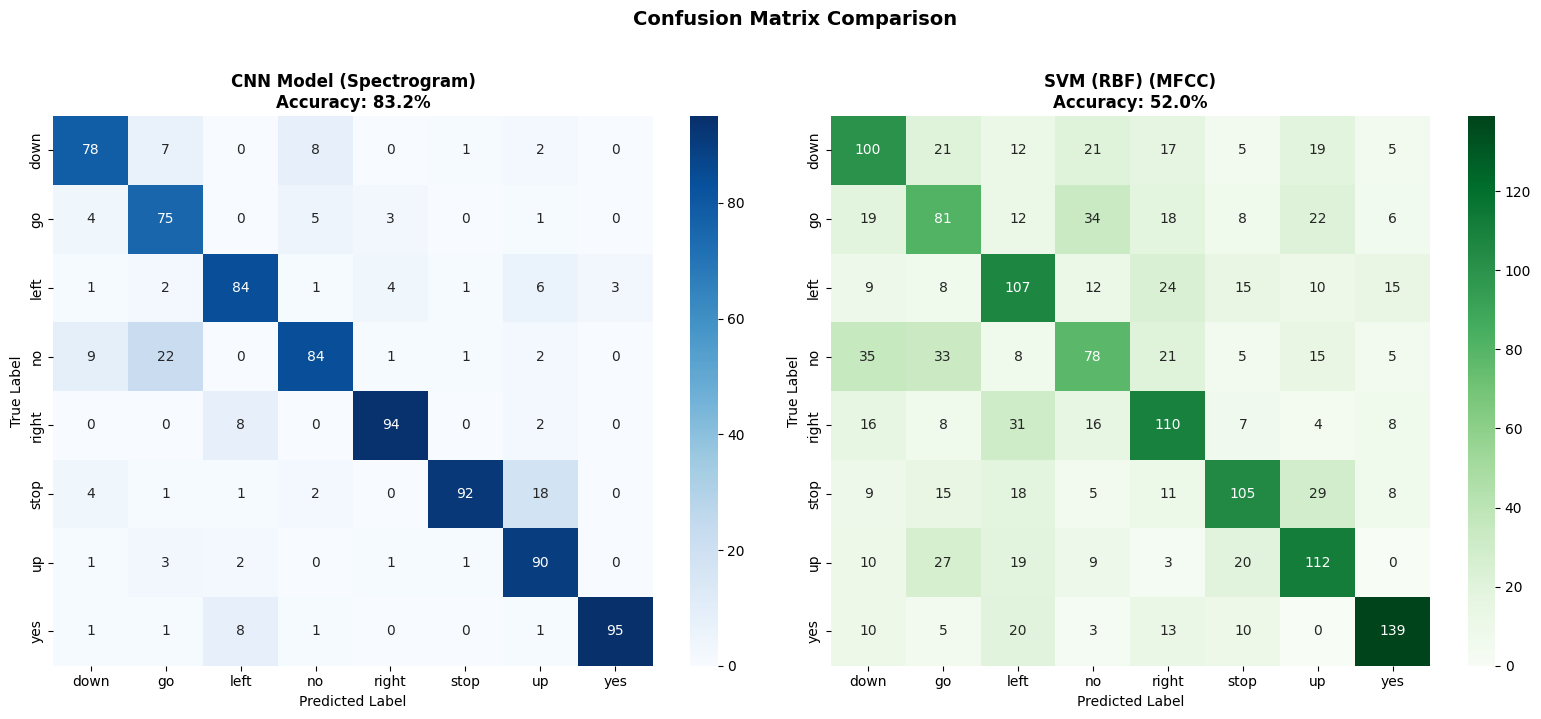

In [27]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# CNN confusion matrix
sns.heatmap(
    cnn_cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    ax=axes[0]
)
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'CNN Model (Spectrogram)\nAccuracy: {cnn_test_accuracy:.1%}', fontsize=12, fontweight='bold')

# Best ML confusion matrix
sns.heatmap(
    ml_cm, 
    annot=True, 
    fmt='d', 
    cmap='Greens',
    xticklabels=mfcc_label_encoder.classes_,
    yticklabels=mfcc_label_encoder.classes_,
    ax=axes[1]
)
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'{best_ml_name} (MFCC)\nAccuracy: {best_ml_accuracy:.1%}', fontsize=12, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/confusion_matrix_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 3.4 Per-Class Performance Comparison


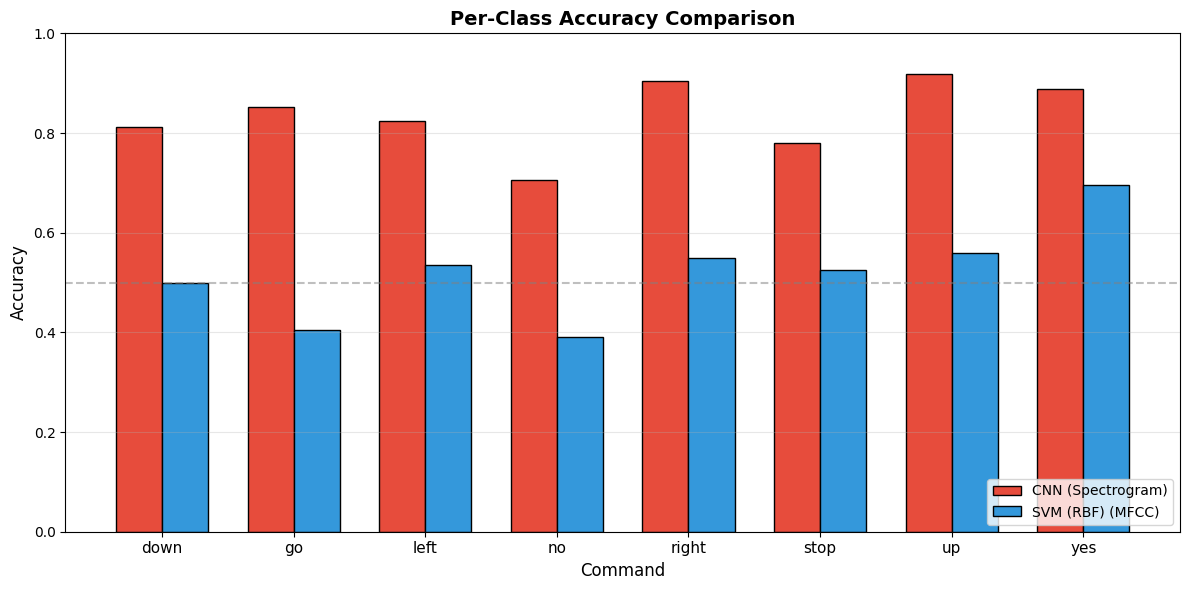

In [28]:
# Calculate per-class accuracy for both models
def get_per_class_accuracy(y_true, y_pred, num_classes):
    class_acc = []
    for i in range(num_classes):
        mask = y_true == i
        if mask.sum() > 0:
            class_acc.append((y_pred[mask] == i).mean())
        else:
            class_acc.append(0)
    return class_acc

cnn_class_acc = get_per_class_accuracy(cnn_y_true, cnn_y_pred, len(label_names))
ml_class_acc = get_per_class_accuracy(ml_y_true, ml_y_pred, len(mfcc_label_encoder.classes_))

# Plot per-class comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(label_names))
width = 0.35

bars1 = ax.bar(x - width/2, cnn_class_acc, width, label='CNN (Spectrogram)', color='#e74c3c', edgecolor='black')
bars2 = ax.bar(x + width/2, ml_class_acc, width, label=f'{best_ml_name} (MFCC)', color='#3498db', edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xlabel('Command', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(label_names, fontsize=11)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/per_class_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 3.5 Feature Comparison: Spectrogram vs MFCC


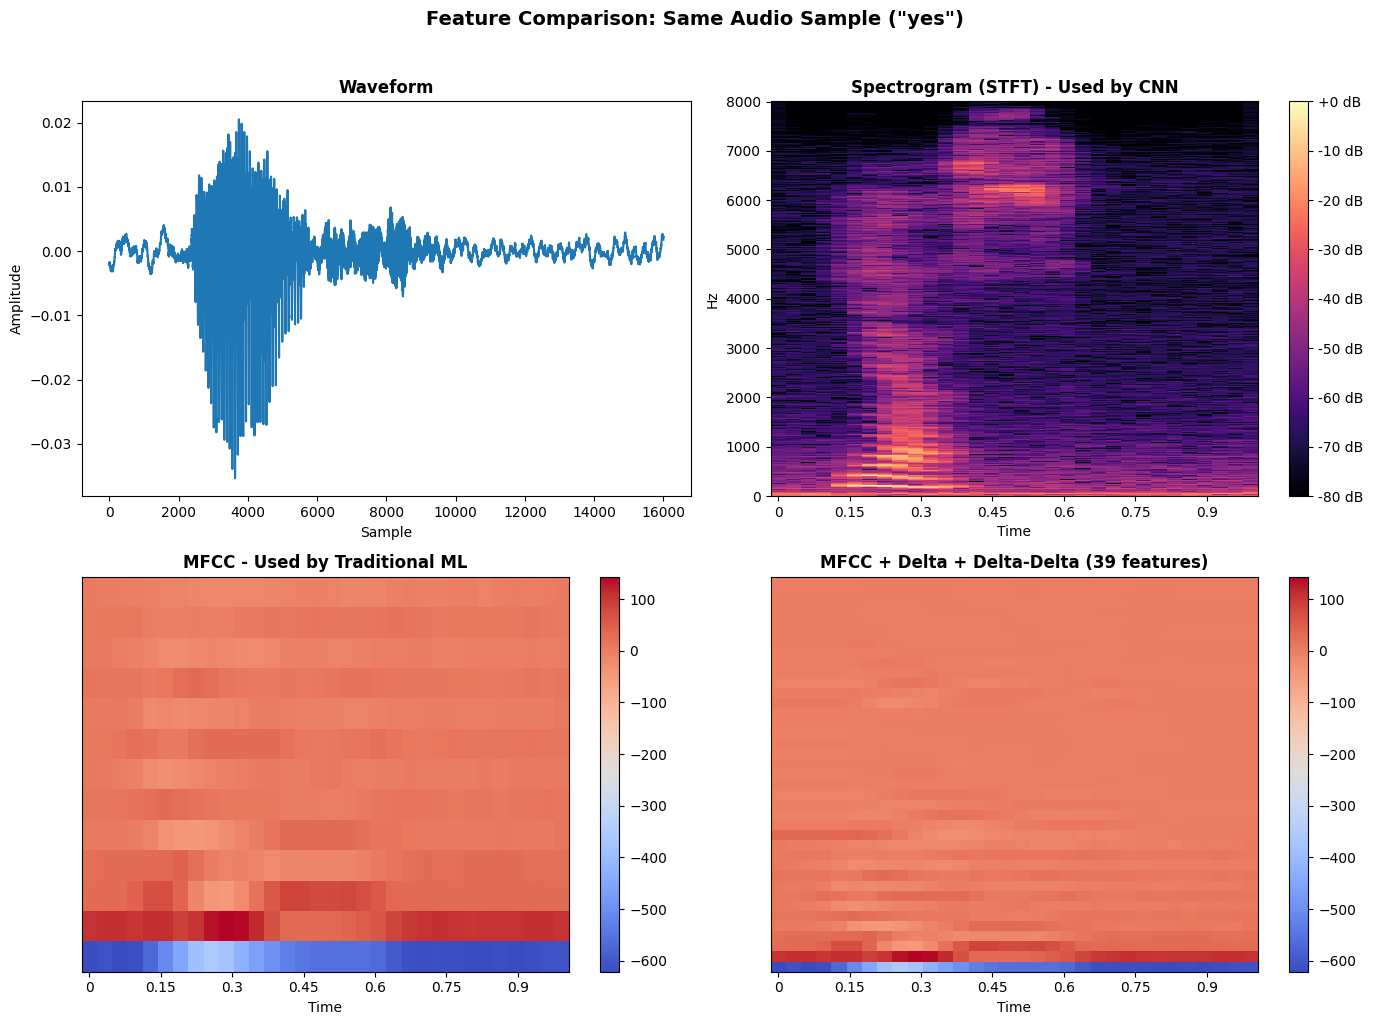

In [29]:
# Visualize both feature types for the same audio
sample_file = list((data_dir / 'yes').glob('*.wav'))[0]
audio_sample, sr_sample = librosa.load(sample_file, sr=SAMPLE_RATE)

# Compute features
mfcc_viz = librosa.feature.mfcc(y=audio_sample, sr=sr_sample, n_mfcc=N_MFCC)
spectrogram_viz = np.abs(librosa.stft(audio_sample))
spectrogram_db = librosa.amplitude_to_db(spectrogram_viz, ref=np.max)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Waveform
axes[0, 0].plot(audio_sample)
axes[0, 0].set_title('Waveform', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Amplitude')

# Spectrogram
img1 = librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='hz', sr=sr_sample, ax=axes[0, 1])
axes[0, 1].set_title('Spectrogram (STFT) - Used by CNN', fontsize=12, fontweight='bold')
fig.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')

# MFCC
img2 = librosa.display.specshow(mfcc_viz, x_axis='time', sr=sr_sample, ax=axes[1, 0])
axes[1, 0].set_title('MFCC - Used by Traditional ML', fontsize=12, fontweight='bold')
fig.colorbar(img2, ax=axes[1, 0])

# MFCC + Deltas
mfcc_delta_viz = librosa.feature.delta(mfcc_viz)
mfcc_delta2_viz = librosa.feature.delta(mfcc_viz, order=2)
mfcc_all = np.vstack([mfcc_viz, mfcc_delta_viz, mfcc_delta2_viz])
img3 = librosa.display.specshow(mfcc_all, x_axis='time', sr=sr_sample, ax=axes[1, 1])
axes[1, 1].set_title('MFCC + Delta + Delta-Delta (39 features)', fontsize=12, fontweight='bold')
fig.colorbar(img3, ax=axes[1, 1])

plt.suptitle('Feature Comparison: Same Audio Sample ("yes")', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figures/feature_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## 3.6 Summary Statistics


In [32]:
# Summary table
print("\n" + "=" * 80)
print("DETAILED COMPARISON SUMMARY")
print("=" * 80)

print("\n APPROACH COMPARISON")
print("-" * 80)
print(f"{'Aspect':<25} {'CNN (Deep Learning)':<30} {'Traditional ML':<25}")
print("-" * 80)
print(f"{'Feature Type':<25} {'Spectrogram (STFT)':<30} {'MFCC + Deltas':<25}")
print(f"{'Feature Extraction':<25} {'Automatic (learned)':<30} {'Hand-crafted':<25}")
print(f"{'Feature Dimensions':<25} {f'{input_shape}':<30} {'39':<25}")
print(f"{'Best Model':<25} {'CNN':<30} {best_ml_name:<25}")
print(f"{'Test Accuracy':<25} {f'{cnn_test_accuracy:.2%}':<30} {f'{best_ml_accuracy:.2%}':<25}")
print(f"{'Parameters':<25} {f'{cnn_model.count_params():,}':<30} {'N/A (non-parametric)':<25}")

print("\n PERFORMANCE IMPROVEMENT")
print("-" * 80)
improvement = cnn_test_accuracy - best_ml_accuracy
relative_improvement = (improvement / best_ml_accuracy) * 100
print(f"CNN outperforms {best_ml_name} by:")
print(f"  - Absolute: {improvement:.2%} accuracy points")
print(f"  - Relative: {relative_improvement:.1f}% improvement")



DETAILED COMPARISON SUMMARY

 APPROACH COMPARISON
--------------------------------------------------------------------------------
Aspect                    CNN (Deep Learning)            Traditional ML           
--------------------------------------------------------------------------------
Feature Type              Spectrogram (STFT)             MFCC + Deltas            
Feature Extraction        Automatic (learned)            Hand-crafted             
Feature Dimensions        (124, 129, 1)                  39                       
Best Model                CNN                            SVM (RBF)                
Test Accuracy             83.17%                         52.00%                   
Parameters                30,494,219                     N/A (non-parametric)     

 PERFORMANCE IMPROVEMENT
--------------------------------------------------------------------------------
CNN outperforms SVM (RBF) by:
  - Absolute: 31.17% accuracy points
  - Relative: 59.9% improvement


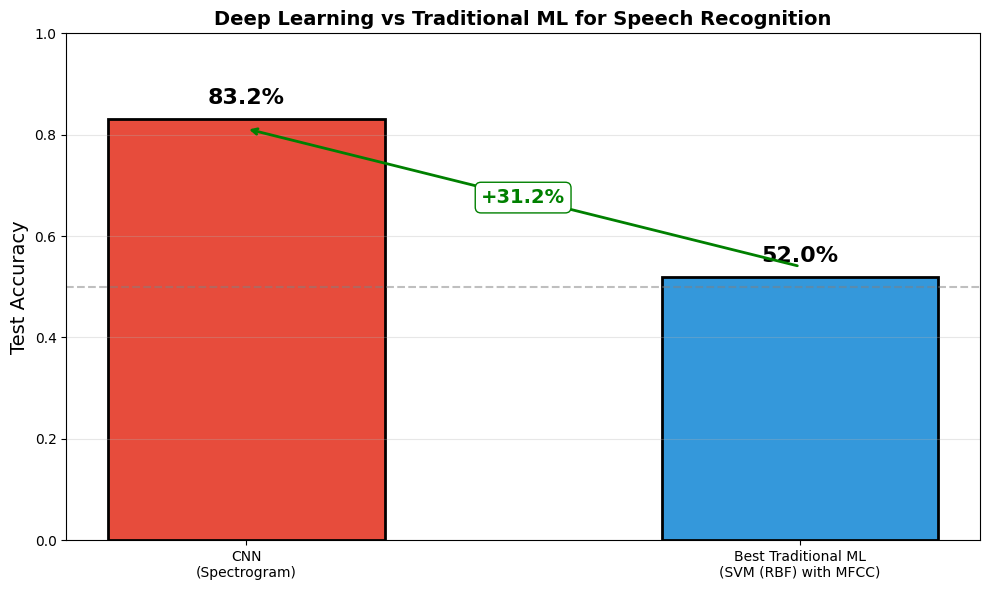

In [31]:
# Final comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Data
approaches = ['CNN\n(Spectrogram)', f'Best Traditional ML\n({best_ml_name} with MFCC)']
accs = [cnn_test_accuracy, best_ml_accuracy]
colors = ['#e74c3c', '#3498db']

bars = ax.bar(approaches, accs, color=colors, edgecolor='black', linewidth=2, width=0.5)

# Add value labels
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{acc:.1%}', ha='center', va='bottom', fontsize=16, fontweight='bold')

# Add improvement arrow
ax.annotate('', xy=(0, cnn_test_accuracy - 0.02), xytext=(1, best_ml_accuracy + 0.02),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax.text(0.5, (cnn_test_accuracy + best_ml_accuracy) / 2, f'+{improvement:.1%}',
        ha='center', va='center', fontsize=14, fontweight='bold', color='green',
        bbox=dict(boxstyle='round', facecolor='white', edgecolor='green'))

ax.set_ylabel('Test Accuracy', fontsize=14)
ax.set_title('Deep Learning vs Traditional ML for Speech Recognition', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
